Importing the Libraries

In [0]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
import numpy as np
from numpy import asarray
import imghdr
import sys
from datetime import datetime

In [0]:
# Setting up Tensor Flow GPU to speed up the computational process for deep learning

In [0]:
gpus = tf.config.list_physical_devices('GPU')

In [0]:
# Avoiding OOM error by setting GPU Memory Consumption Growth

In [0]:
for gpu in gpus:
    tf.config.set_memory_growth(gpu,True)

In [0]:
# ! pip list

In [0]:
# Uploading the training and Validation dataset to the DBFS folder in the databricks. Here, the folder name is all_data
# Sub folder for the good roads' images data - shared_uploads/singh.indiap@gmail.com/all_data/Good/
# Sub folder for the poor roads' images data - shared_uploads/singh.indiap@gmail.com/all_data/Poor/

In [0]:
all_data = "/dbfs/FileStore/shared_uploads/singh.indiap@gmail.com/all_data"

In [0]:
# generating dataframes for good and poor images' data

In [0]:
df_poor = spark.read.format("image").load("dbfs:/FileStore/shared_uploads/singh.indiap@gmail.com/all_data/Poor/")
df_good = spark.read.format("image").load("dbfs:/FileStore/shared_uploads/singh.indiap@gmail.com/all_data/Good/")

In [0]:
print("Good Images Count:- ",df_good.count())
print("Poor Images Count:- ",df_poor.count())

Good Images Count:-  7360
Poor Images Count:-  7354


Removing Bad datasets (dodgy images here)

In [0]:
# We will only consider the following extensions of the images in our dataset which are .jpeg, .jpg, .png, .bmp. We will remove the files of any other extensions.

In [0]:
image_exts = ['jpeg','jpg','png','bmp']

In [0]:
# Getting the list of directories present inside the main directory, which is 'all_data' here.

In [0]:
os.listdir(all_data)

['Good', 'Poor']

In [0]:
# Printing the different image classes present in the 'all_data' directory, main directory.

In [0]:
for image_class in os.listdir(all_data):
    print(image_class)

Good
Poor


In [0]:
for image_class in os.listdir(all_data):
    for image in os.listdir(os.path.join(all_data,image_class)):
        image_path = os.path.join(all_data,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path) # tip is extension of the image
            if tip not in image_exts:
                print('Image not in ext list{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [0]:
# Printing the image and the shape of the image named 'PE_AR_46398_111_1-1.jpg'

In [0]:
img = cv2.imread(os.path.join(all_data,'Good','PE_AR_46398_111_1-1.jpg'))

In [0]:
type(img)

numpy.ndarray

In [0]:
img.shape

(512, 230, 3)

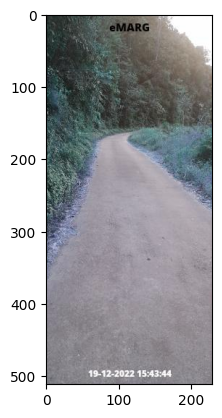

In [0]:
plt.imshow(img)

Loading Data

In [0]:
# Generating a tf.data.Dataset from image files in the main directory, here 'all_data'. no

In [0]:
img_data = tf.keras.utils.image_dataset_from_directory(all_data)

Found 14714 files belonging to 2 classes.


In [0]:
# The function image_dataset_from_directory automatically creates labels for each image, based on the name of the directory it's in ( class_1 , class_2 , etc.). The following code will print out the labels for each batch of images in the dataset.

In [0]:
img_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [0]:
# The as_numpy_iterator() function returns an iterator which converts all elements of the dataset to numpy.

In [0]:
img_data_iterator = img_data.as_numpy_iterator()

In [0]:
img_data_iterator

In [0]:
batch_img = img_data_iterator.next()

In [0]:
batch_img

(array([[[[ 79.25     ,  72.75     ,  21.       ],
          [ 97.25     ,  91.75     ,  51.5      ],
          [ 96.75     ,  94.5      ,  68.125    ],
          ...,
          [235.       , 246.       , 252.       ],
          [234.       , 245.       , 251.       ],
          [233.625    , 244.625    , 250.625    ]],
 
         [[ 70.25     ,  63.375    ,  14.25     ],
          [130.25     , 124.75     ,  86.       ],
          [ 70.875    ,  67.875    ,  42.625    ],
          ...,
          [235.375    , 246.375    , 252.375    ],
          [234.375    , 245.375    , 251.375    ],
          [234.       , 245.       , 251.       ]],
 
         [[ 69.625    ,  61.5      ,  15.75     ],
          [107.625    , 100.5      ,  65.75     ],
          [ 90.375    ,  86.375    ,  63.125    ],
          ...,
          [236.       , 247.       , 253.       ],
          [235.125    , 246.125    , 252.125    ],
          [234.25     , 245.25     , 251.25     ]],
 
         ...,
 
         [[1

In [0]:
len(batch_img)

2

In [0]:
# Image represented as numpy arrays
batch_img[0].shape

(32, 256, 256, 3)

In [0]:
batch_img[1]
# 0 for Good and 1 for Poor

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1], dtype=int32)

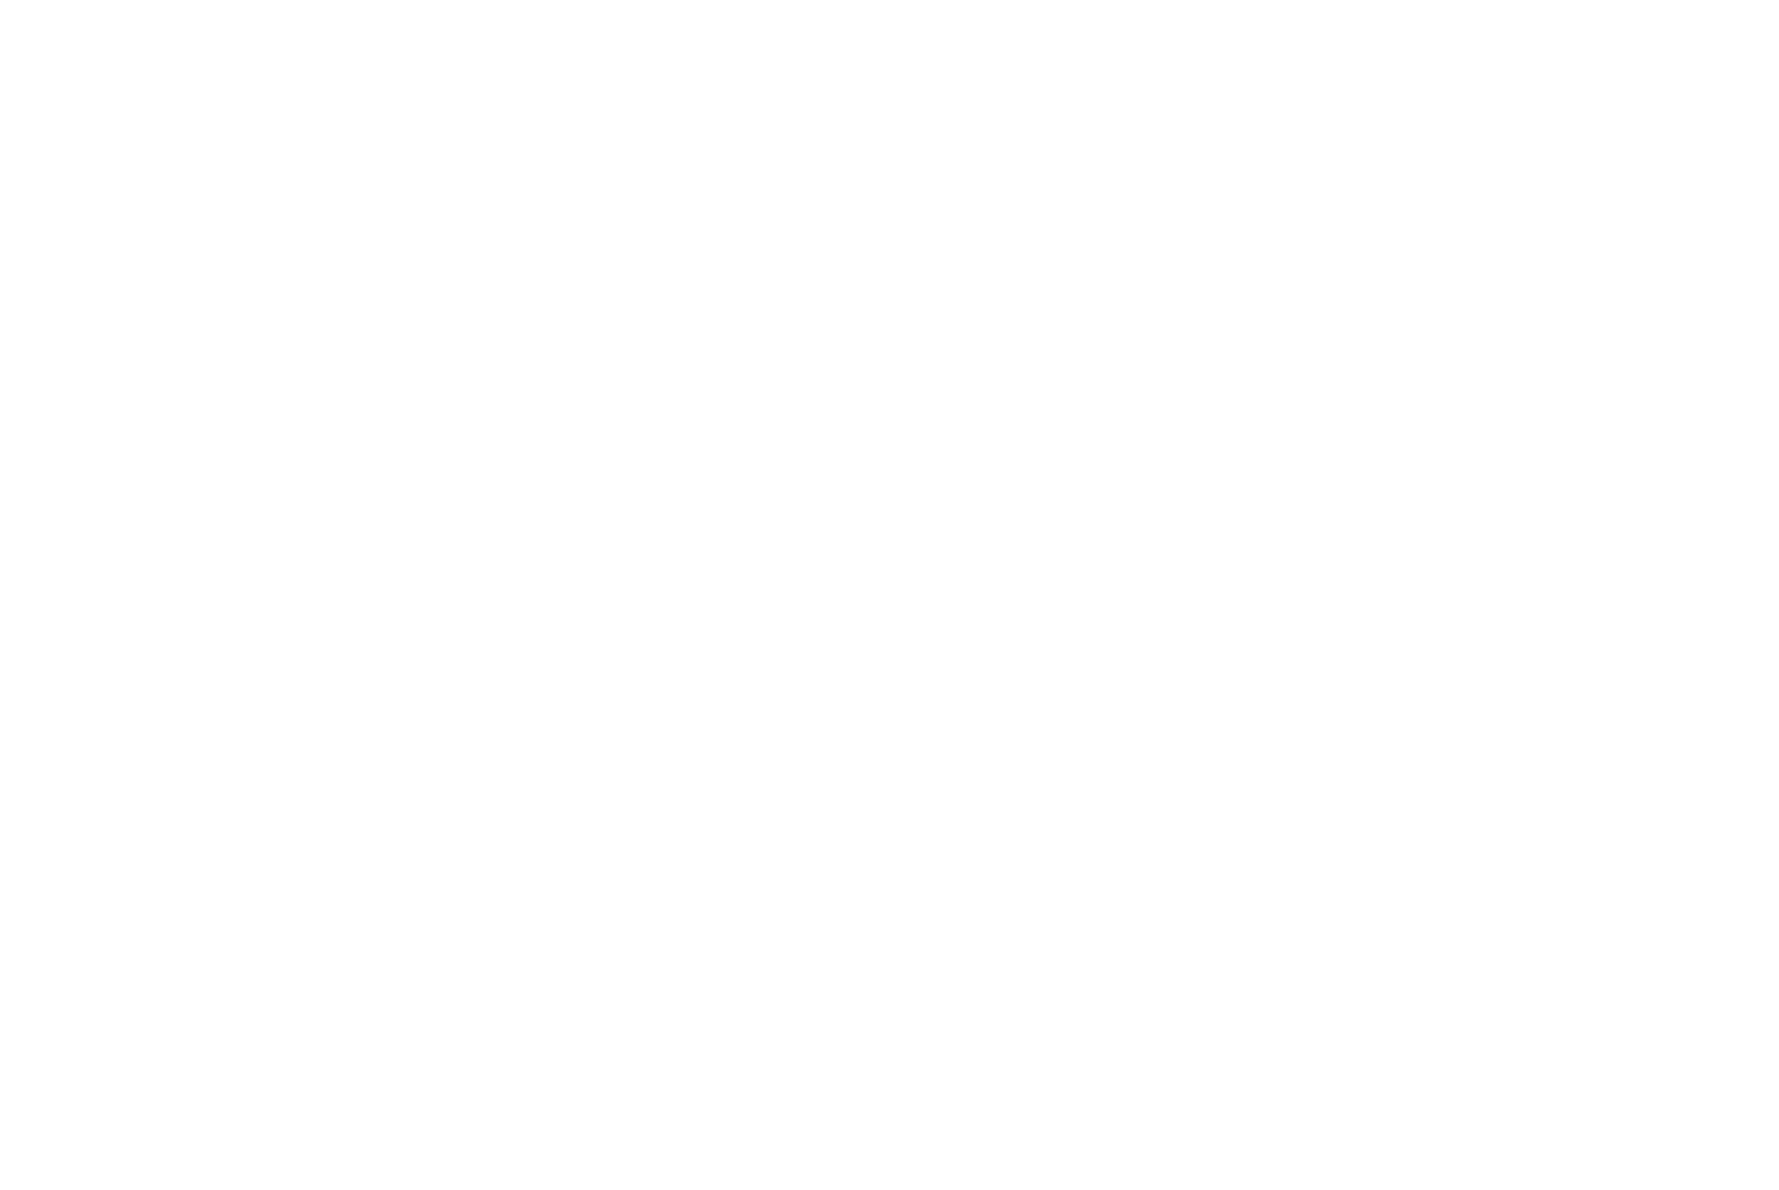

In [0]:
fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch_img[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch_img[1][idx])

In [0]:
batch_img[0].max() 

255.0

In [0]:
# Scaling the data

In [0]:
scaled = batch_img[0]/255

In [0]:
scaled.max()

1.0

Preprocess data

In [0]:
data_map = img_data.map(lambda x,y: (x/255,y))

In [0]:
scaled_iterator = data_map.as_numpy_iterator()

In [0]:
scaled_batch = scaled_iterator.next()

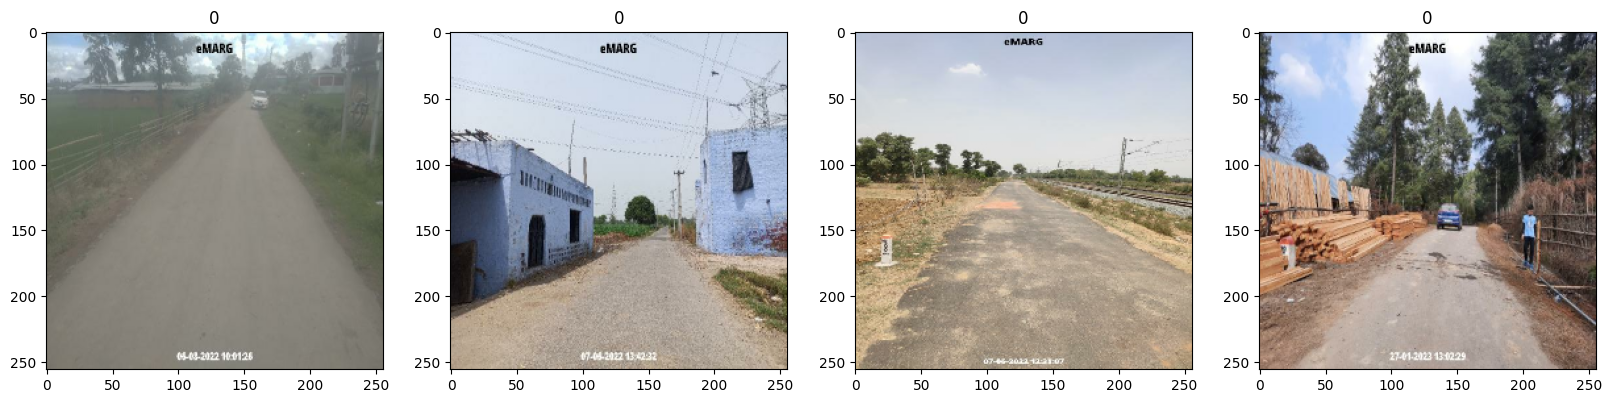

In [0]:
fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

Partitioning the dataset

In [0]:
len(img_data)

460

In [0]:
# Partitioning the dataset into train (70%), validation (20%), and test (10%)

In [0]:
train_size = int(len(img_data)*.7)
val_size = int(len(img_data)*.2)
test_size = int(len(img_data)*.1)

In [0]:
train = img_data.take(train_size)
val = img_data.skip(train_size).take(val_size)
test = img_data.skip(train_size+val_size).take(test_size)

Building Model

In [0]:
# Building Deep Learning Model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [0]:
model = Sequential()

In [0]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [0]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [0]:
# Training the model

In [0]:
logdirs = '/dbfs/FileStore/shared_uploads/singh.indiap@gmail.com/logs'

In [0]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdirs)

In [0]:
hist = model.fit(img_data, epochs=20, validation_data= val, callbacks=[tensorboard_callback])

Epoch 1/20
144/460 [========>.....................] - ETA: 4:39 - loss: 4.4462 - accuracy: 0.4946

*** WARNING: max output size exceeded, skipping output. ***

460/460 [==============================] - 575s 1s/step - loss: 0.5395 - accuracy: 0.6723 - val_loss: 0.5788 - val_accuracy: 0.6349


In [0]:
hist.history

{'loss': [1.8685859441757202,
  0.692521333694458,
  0.6907291412353516,
  0.6920923590660095,
  0.6897710561752319,
  0.68888258934021,
  0.6830205321311951,
  0.6760818362236023,
  0.6644333004951477,
  0.6651268601417542,
  0.6563575863838196,
  0.6536415219306946,
  0.6459605097770691,
  0.6349745988845825,
  0.6262842416763306,
  0.6155676245689392,
  0.6036956310272217,
  0.5833171010017395,
  0.5589796304702759,
  0.5394963026046753],
 'accuracy': [0.5023787021636963,
  0.5002039074897766,
  0.5101264119148254,
  0.5037379264831543,
  0.5092428922653198,
  0.5137284398078918,
  0.5251461267471313,
  0.5330977439880371,
  0.5474377870559692,
  0.5483213067054749,
  0.5515835285186768,
  0.559195339679718,
  0.5610303282737732,
  0.5728557705879211,
  0.5862444043159485,
  0.6010602116584778,
  0.6117303371429443,
  0.6298763155937195,
  0.6515563130378723,
  0.6722849011421204],
 'val_loss': [0.6922325491905212,
  0.6896928548812866,
  0.6907137632369995,
  0.6883634924888611,
  

In [0]:
# Plotting the performance

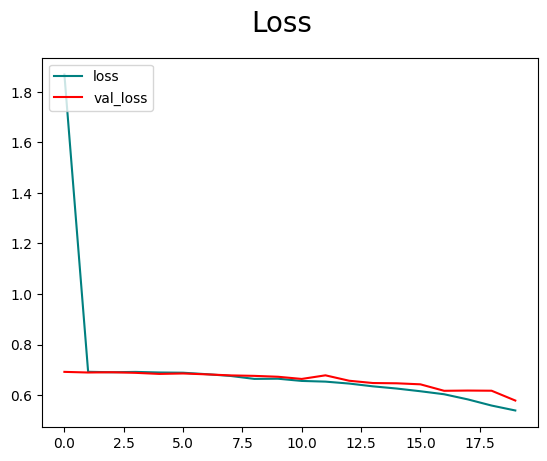

In [0]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='red',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

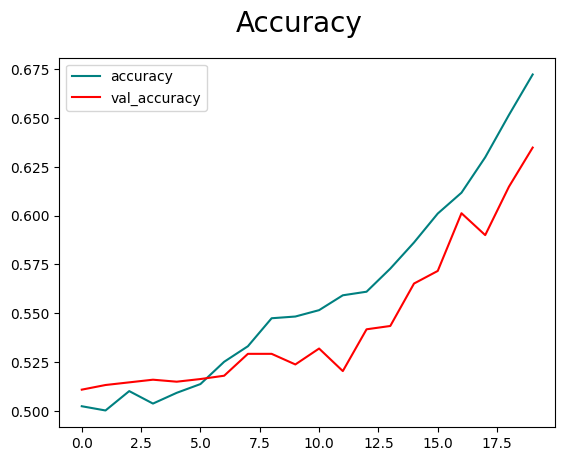

In [0]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='red',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluating performance

In [0]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [0]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [0]:
for test_batch in test.as_numpy_iterator():
    X,y=test_batch
    yhat=model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 274ms/step


In [0]:
# Testing the model

In [0]:
from PIL import Image

In [0]:
img = Image.open('/dbfs/FileStore/shared_uploads/singh.indiap@gmail.com/testd/poor.jpg')

In [0]:
print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=259x194 at 0x7FC48844D3F0>


In [0]:
np_img = asarray(img)

In [0]:
resize = tf.image.resize(np_img, (256,256))

In [0]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 31ms/step


In [0]:
yhat

array([[1.]], dtype=float32)

In [0]:
# Since here, we have class 0 for Good and 1 for Poor, thus condition is given accordingly:
if yhat>0.5:
    print("Predicted Road is Poor ")
else:
    print("Predicted Road is Good")

Predicted Road is Poor 


Saving the Model

In [0]:
# Importing the pickle library for saving the model in .pkl file

In [0]:
import pickle

In [0]:
model_pkl_file = "road_classifier_mode.pkl"  

In [0]:
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

In [0]:
type(model_pkl_file)

str

In [0]:
pickled_model = pickle.load(open('road_classifier_mode.pkl', 'rb'))

In [0]:
pickled_model.predict(X_test)